In [1]:
import pandas as pd
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [ ]:
file_path = r'C:\Users\Admin\OneDrive\Desktop\car_dheko\Car_Dheko\*.csv'
csv_files = glob.glob(file_path )

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.drop(columns=["Unnamed: 0","Rear Brake Type"],axis=1,inplace=True)
df["price"]=df["price"].astype(int)
df["Kms Driven"]=df["Kms Driven"].astype(int)

Filter by top features

In [28]:
Features=["modelYear","model",'Year of Manufacture','Wheel Base','Width','state','Max Power',
          'RTO','Registration Year','Kms Driven','centralVariantId',"price"]


df=df[Features]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   modelYear            8369 non-null   int64  
 1   model                8369 non-null   object 
 2   Year of Manufacture  8369 non-null   float64
 3   Wheel Base           8369 non-null   int64  
 4   Width                8369 non-null   int64  
 5   state                8369 non-null   object 
 6   Max Power            8309 non-null   object 
 7   RTO                  7475 non-null   object 
 8   Registration Year    8369 non-null   int64  
 9   Kms Driven           8369 non-null   int64  
 10  centralVariantId     8369 non-null   int64  
 11  price                8369 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 784.7+ KB


Outlir Detection

In [30]:
def outlier(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3 - q1
    whisker1 = q1 - 1.5 * IQR
    whisker2 = q3 + 1.5 * IQR
    return whisker1, whisker2

for column in df.select_dtypes(include=['number']).columns:
    whisker1, whisker2 = outlier(df, column)
    df = df[(df[column] >= whisker1) & (df[column] <= whisker2)]

In [31]:
df.describe()

,modelYear,Year of Manufacture,Wheel Base,Width,Registration Year,Kms Driven,centralVariantId,price
count,6381.000000,6381.000000,6381.000000,6381.000000,6381.000000,6381.000000,6381.000000,6.381000e+03
mean,2016.649585,2016.649585,2520.675129,1717.945150,2016.719793,58826.568406,4899.712741,6.380595e+05
std,3.384884,3.384884,102.430361,68.247846,3.384248,32414.056524,2734.544067,3.129963e+05
min,2007.000000,2007.000000,2258.000000,1550.000000,2008.000000,600.000000,13.000000,5.500000e+04
25%,2014.000000,2014.000000,2435.000000,1680.000000,2014.000000,33000.000000,1932.000000,4.170000e+05
50%,2017.000000,2017.000000,2519.000000,1729.000000,2017.000000,55940.000000,5431.000000,5.900000e+05
75%,2019.000000,2019.000000,2590.000000,1760.000000,2019.000000,80000.000000,7091.000000,8.000000e+05
max,2023.000000,2023.000000,2874.000000,1918.000000,2023.000000,154931.000000,11098.000000,1.600000e+06


Encoding & mpute Null

In [32]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])
    label_encoders[col] = label_encoder
df_filtered = df.copy()
for column, encoder in label_encoders.items():
    df_filtered[column] = encoder.inverse_transform(df_filtered[column])                                                

In [33]:
df_filtered.head(4)

,modelYear,model,Year of Manufacture,Wheel Base,Width,state,Max Power,RTO,Registration Year,Kms Driven,centralVariantId,price
0,2015,Maruti Celerio,2015.0,2425,1635,bangalore,67.04bhp@6000rpm,KA51,2015,120000,3979,400000
1,2018,Ford Ecosport,2018.0,2519,1765,bangalore,121.31bhp@6500rpm,KA05,2018,32706,6087,811000
2,2018,Tata Tiago,2018.0,2400,1647,bangalore,84bhp@6000rpm,KA03,2018,11949,2983,585000
3,2014,Hyundai Xcent,2014.0,2425,1660,bangalore,81.86bhp@6000rpm,KA53,2014,17794,1867,462000


In [34]:
# Year of Manufacture is highly correlation with model and Registration Year based in head map
df.drop(columns=["Year of Manufacture",	"modelYear"],inplace=True)  
df_filtered.drop(columns=["Year of Manufacture","modelYear"],inplace=True) 
                                        

In [23]:
# save the dataframe
df_filtered.to_excel("final_data.xlsx")

In [35]:
df_filtered.head(2)

,model,Wheel Base,Width,state,Max Power,RTO,Registration Year,Kms Driven,centralVariantId,price
0,Maruti Celerio,2425,1635,bangalore,67.04bhp@6000rpm,KA51,2015,120000,3979,400000
1,Ford Ecosport,2519,1765,bangalore,121.31bhp@6500rpm,KA05,2018,32706,6087,811000


Univariant Analysis

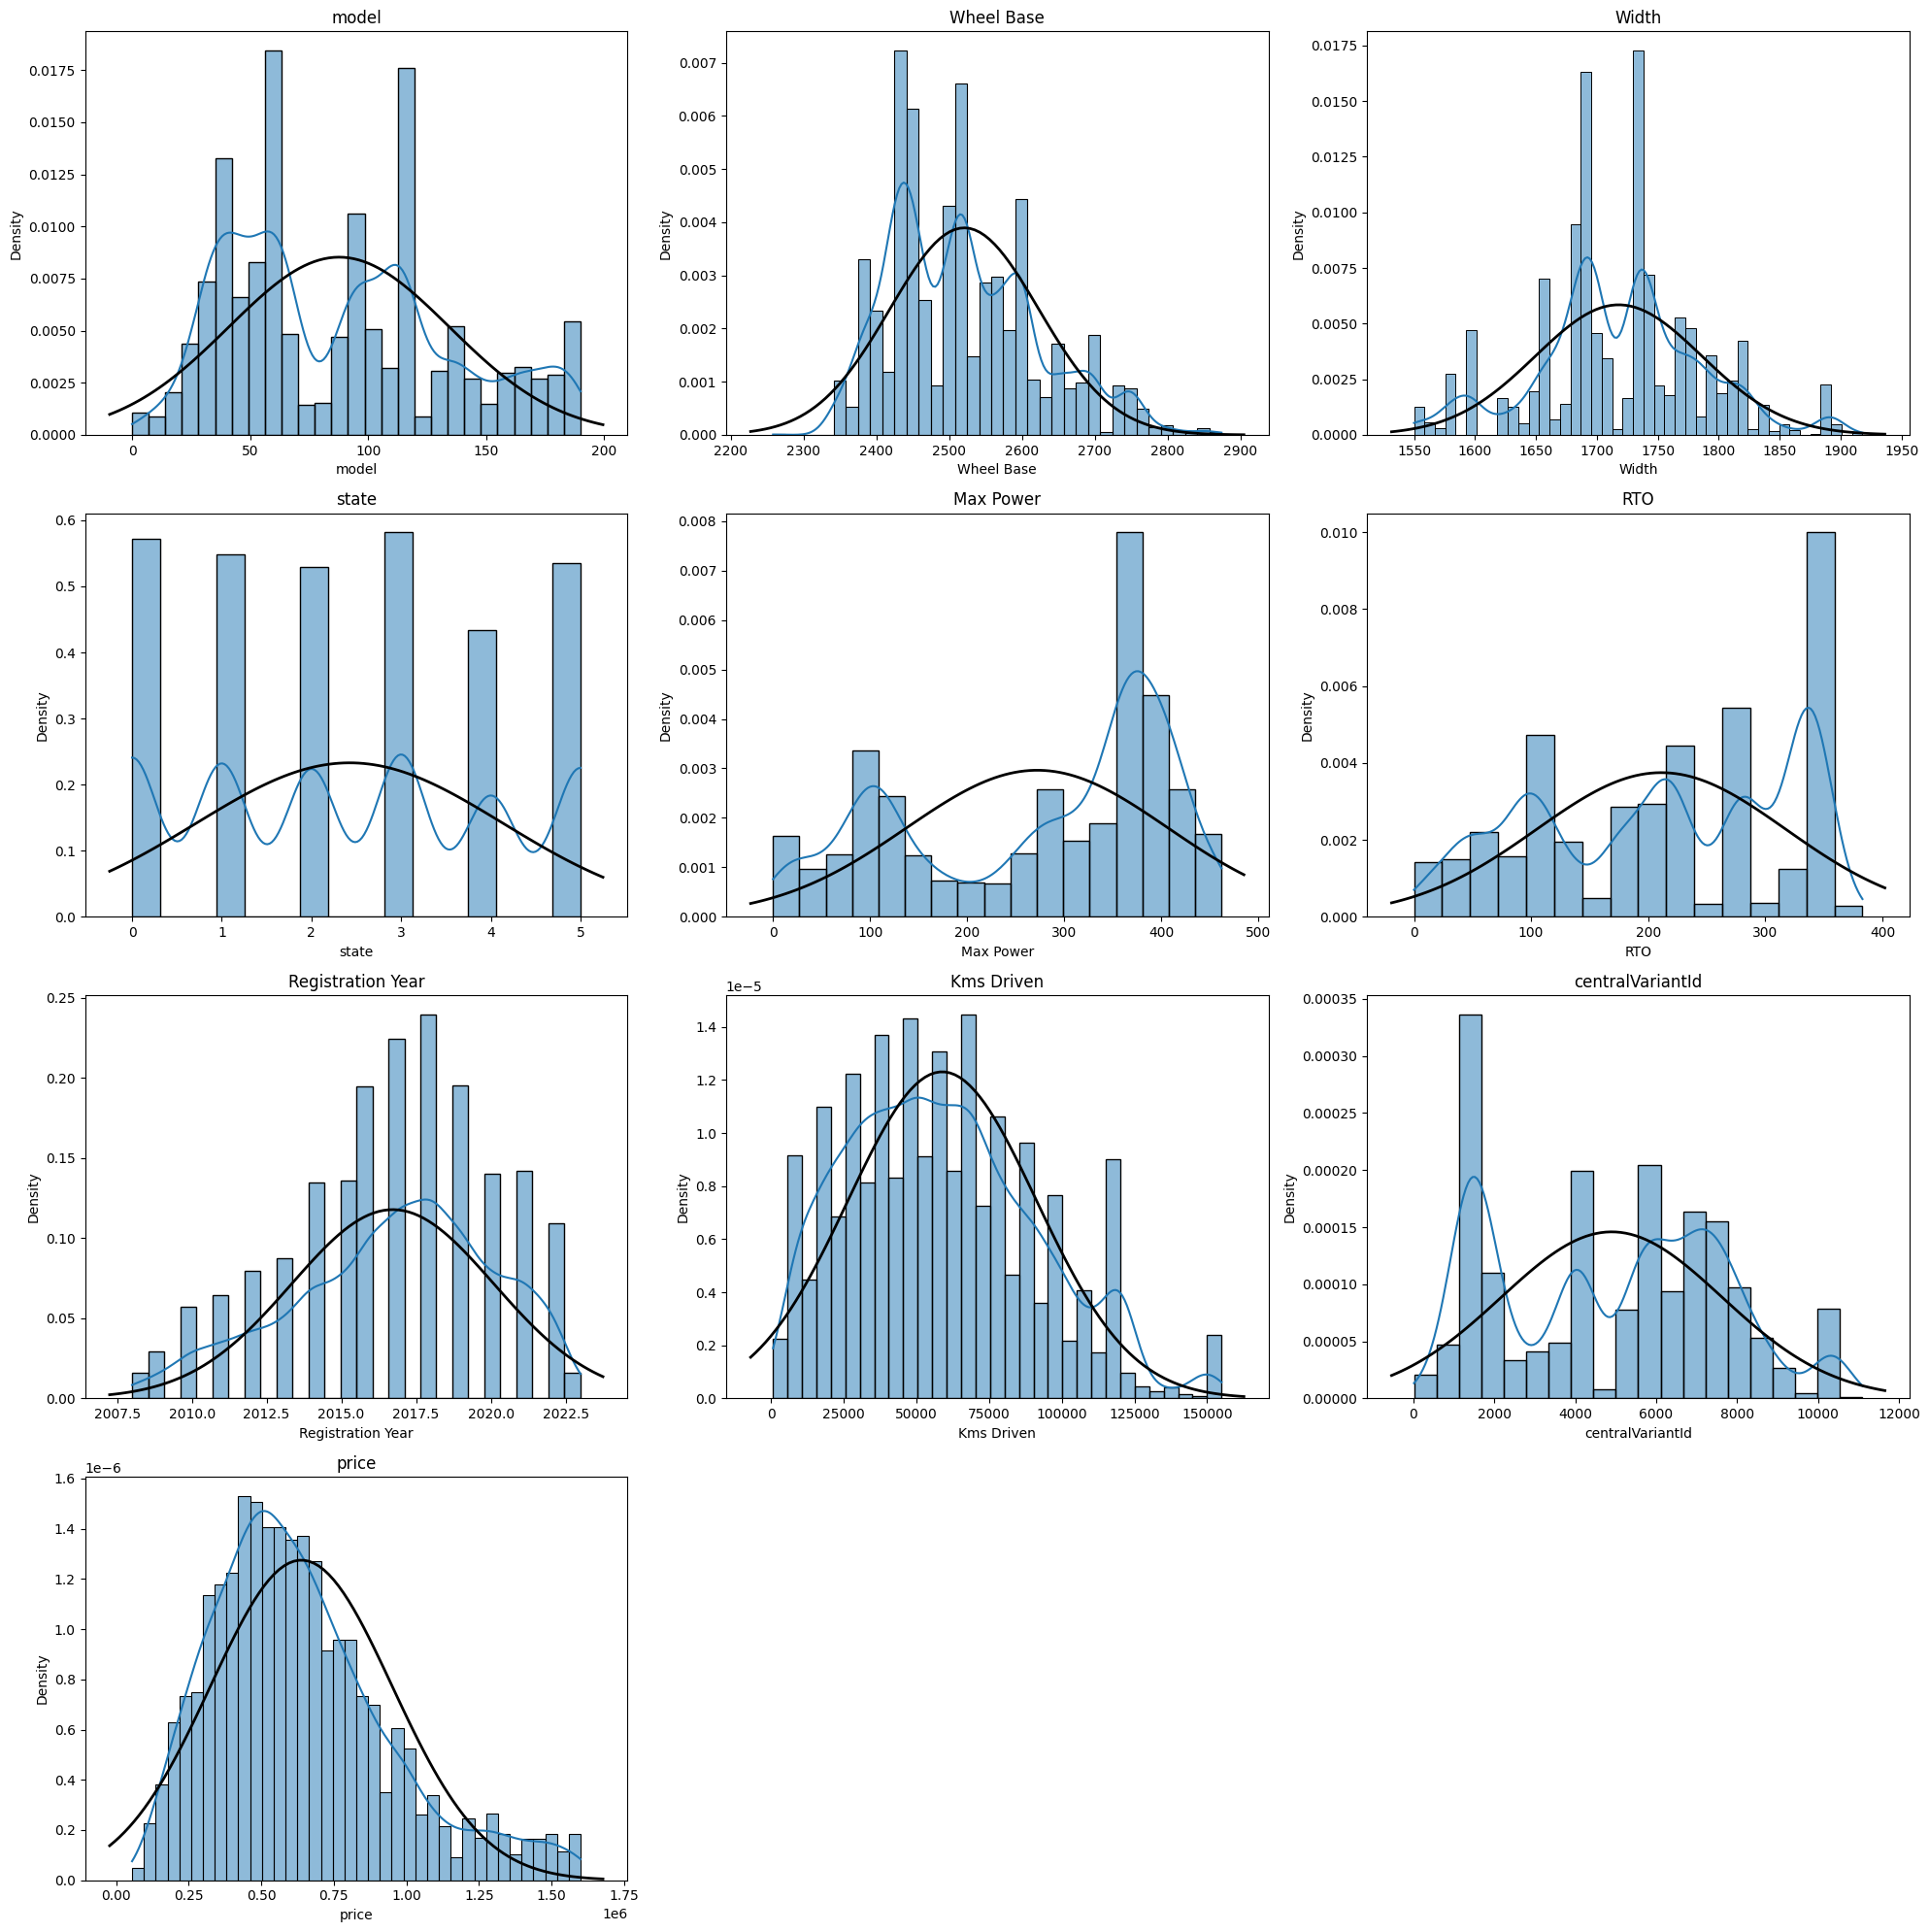

In [24]:
data = df
num_columns = len(data.columns)
nrows = (num_columns // 3) + (num_columns % 3 > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, 5*nrows))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    sns.histplot(data[column], kde=True, ax=axes[i], stat="density")
    mu, std = norm.fit(data[column])
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[i].plot(x, p, 'k', linewidth=2)
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('Density')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Head map (correlation analysis)

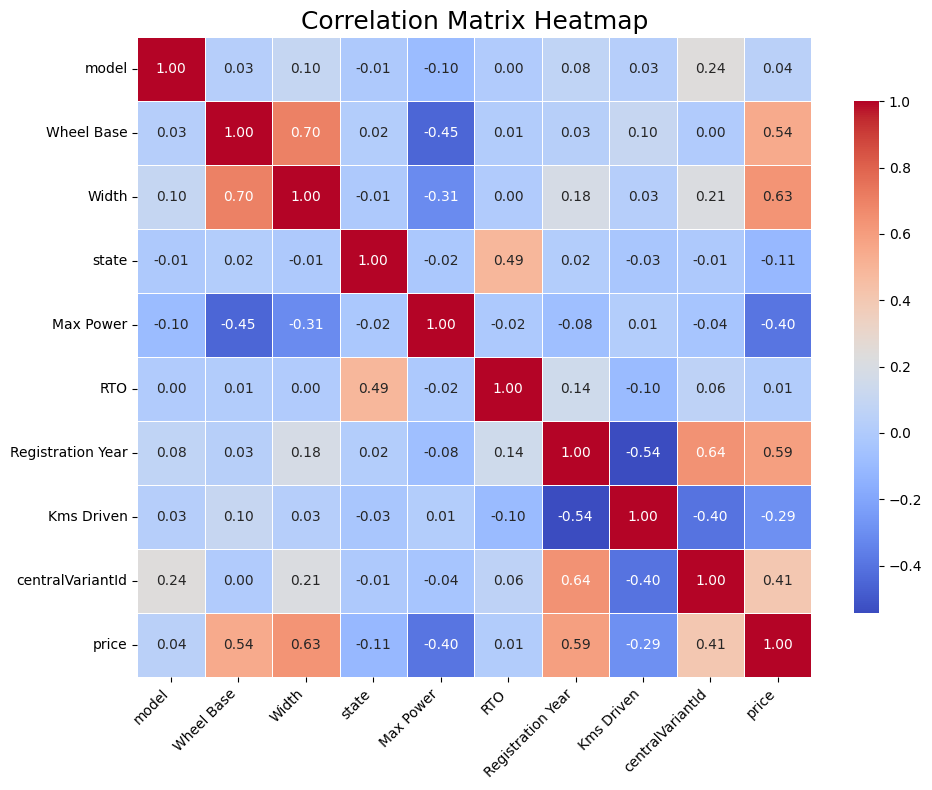

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


Linear Regression

In [36]:
X = df.drop(columns=["price"])
y= df["price"]
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42,shuffle=True)
model = LinearRegression()
model.fit(x_train,y_train)
pred_y=model.predict(x_test)
mse = mean_squared_error(y_test, pred_y)
mse = mean_squared_error(y_test, pred_y)
mae = mean_absolute_error(y_test, pred_y)
r2 = r2_score(y_test, pred_y)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Squared Error: 26611896643.92974
Mean Absolute Error: 116260.456278144
R-squared: 0.7292675230984005


RandomForestRegressor

In [37]:
model = RandomForestRegressor()
model.fit(x_train, y_train)
pred_y=model.predict(x_test)
mse = mean_squared_error(y_test, pred_y)
mse = mean_squared_error(y_test, pred_y)
mae = mean_absolute_error(y_test, pred_y)
r2 = r2_score(y_test, pred_y)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Squared Error: 10489722138.750381
Mean Absolute Error: 68429.49174391867
R-squared: 0.8932842519782885


grid search with randam forest

In [38]:
rf = RandomForestRegressor(random_state=42)

# Step 2: Set up the parameter grid
param_grid = {
    'n_estimators': [300],
    'max_depth': [30],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2, 
)

grid_search.fit(x_train, y_train)

pred_y=grid_search.predict(x_test)

mse = mean_squared_error(y_test, pred_y)
mae = mean_absolute_error(y_test, pred_y)
r2 = r2_score(y_test, pred_y)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mean Squared Error: 10337132032.932793
Mean Absolute Error: 68081.19649673213
R-squared: 0.8948366064703949


Decision Tree

In [39]:
model = DecisionTreeRegressor(random_state=42)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Squared Error: 20748614416.88097
Mean Absolute Error: 95334.00861393892
R-squared: 0.7889168198524568


Gradient decent

In [40]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Squared Error: 12514693465.370836
Mean Absolute Error: 76221.88684116
R-squared: 0.872683484199652


Grid search with Gradient Decent

In [44]:
model = GradientBoostingRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.2],
    'max_depth': [5],
    'min_samples_split': [4],
    'min_samples_leaf': [2],
    'subsample': [0.8]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the model with the grid search
grid_search.fit(x_train, y_train)


# Predict using the model with the best-found parameters
y_pred = grid_search.best_estimator_.predict(x_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mean Squared Error: 9778261071.317217
Mean Absolute Error: 65919.34462823151
R-squared: 0.9005222034697759


xtream Gradient  boosting

In [45]:
import xgboost as xgb
from xgboost import XGBRegressor
model=XGBRegressor()
model.fit(x_train,y_train)
pred_y=model.predict(x_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, pred_y)
mae = mean_absolute_error(y_test, pred_y)
r2 = r2_score(y_test, pred_y)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Squared Error: 9834333761.717022
Mean Absolute Error: 67096.84685787001
R-squared: 0.8999517560005188


Grid search with xtream Gradient  boosting

In [46]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
model = XGBRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [300],
    'max_depth': [5],
    'learning_rate': [0.01],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(x_train, y_train)

# Predict using the best model
pred_ = grid_search.predict(x_test)

mse = mean_squared_error(y_test, pred_)
mae = mean_absolute_error(y_test, pred_)
r2 = r2_score(y_test, pred_)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Mean Squared Error: 13115203290.630743
Mean Absolute Error: 79290.3886672866
R-squared: 0.8665742874145508
